# Generative Adversarial Networks (GANs)

In [23]:
import adamirror

In [13]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

## Dataset

Extracting ../../../datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../../datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../../datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../../datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


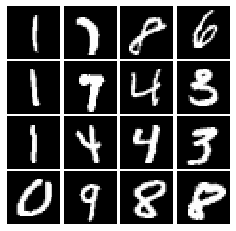

In [14]:
#import input_data
#import mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../../datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

In [15]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x,alpha * x)


## Random Noise

In [16]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform(shape=(batch_size,dim), minval = -1, maxval = 1)


## Discriminator

In [17]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.layers.dense(x,256,activation=leaky_relu)
        x = tf.layers.dense(x,256,activation=leaky_relu)
        logits = tf.layers.dense(x,1,activation=None)
        return logits

## Generator

In [18]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        z = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        z = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        img = tf.layers.dense(z, 784, activation = tf.nn.tanh)
        return img

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.


In [19]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    part1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real), logits = logits_real))
    part2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake), logits = (logits_fake)))
    D_loss = part1 + part2
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_fake), logits = logits_fake ))
    return D_loss, G_loss

# Optimizing our loss
We use optimistic FTRL first

In [39]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
  #  D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
  #  G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    
  #  D_solver = tf.train.AdagradOptimizer(learning_rate = learning_rate)
  #  G_solver = tf.train.AdagradOptimizer(learning_rate = learning_rate)
    
   # D_solver = tf.train.FtrlOptimizer(learning_rate = learning_rate)
   # G_solver = tf.train.FtrlOptimizer(learning_rate = learning_rate)
    
   # D_solver = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
   # G_solver = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    
    D_solver = adamirror.AdamirrorOptimizer(learning_rate = learning_rate, beta1 = beta1) #optimistic MD (optimistic FTRL)
    G_solver = adamirror.AdamirrorOptimizer(learning_rate = learning_rate, beta1 = beta1)
        
    
    
    return D_solver, G_solver

## Putting it all together

In [40]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars) 
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN! 

In [41]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    print (max_iter)
    Gloss = np.zeros(max_iter)
    Dloss = np.zeros(max_iter)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])
        
        #print(G_loss_curr)
        Gloss[it] = G_loss_curr
        Dloss[it] = D_loss_curr
        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()
    
    plt.plot(Gloss)
    plt.ylabel('Generator loss')
    plt.show()
    return Gloss, Dloss

4296


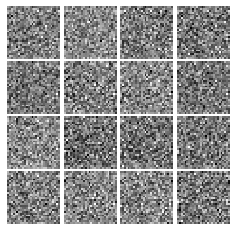


Iter: 0, D: 1.321, G:0.7094
Iter: 50, D: 0.4588, G:1.045
Iter: 100, D: 0.0117, G:4.725
Iter: 150, D: 0.6175, G:1.253
Iter: 200, D: 1.237, G:1.057


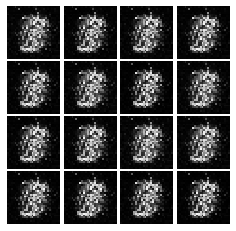


Iter: 250, D: 1.294, G:1.07
Iter: 300, D: 1.53, G:0.568
Iter: 350, D: 1.091, G:1.011
Iter: 400, D: 1.34, G:0.6699
Iter: 450, D: 1.014, G:0.9182


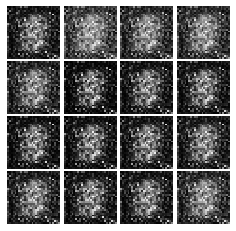


Iter: 500, D: 1.28, G:1.807
Iter: 550, D: 1.478, G:0.5525
Iter: 600, D: 1.184, G:1.099
Iter: 650, D: 1.45, G:1.198
Iter: 700, D: 1.357, G:1.151


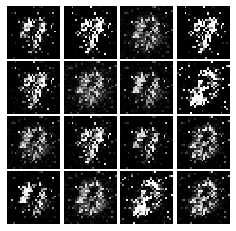


Iter: 750, D: 1.288, G:1.072
Iter: 800, D: 1.163, G:1.004
Iter: 850, D: 1.262, G:0.8627
Iter: 900, D: 1.468, G:0.515
Iter: 950, D: 1.331, G:0.8275


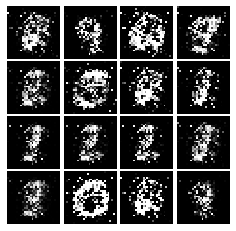


Iter: 1000, D: 1.367, G:0.9459
Iter: 1050, D: 1.34, G:0.9106
Iter: 1100, D: 1.154, G:0.672
Iter: 1150, D: 1.436, G:0.8569
Iter: 1200, D: 1.384, G:0.8217


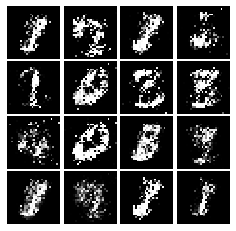


Iter: 1250, D: 1.396, G:0.7817
Iter: 1300, D: 1.374, G:0.7836
Iter: 1350, D: 1.366, G:0.8507
Iter: 1400, D: 1.456, G:0.7188
Iter: 1450, D: 1.451, G:0.8034


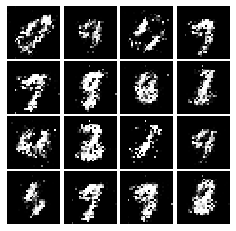


Iter: 1500, D: 1.333, G:0.7928
Iter: 1550, D: 1.323, G:0.8007
Iter: 1600, D: 1.39, G:0.8932
Iter: 1650, D: 1.327, G:0.7537
Iter: 1700, D: 1.34, G:0.7892


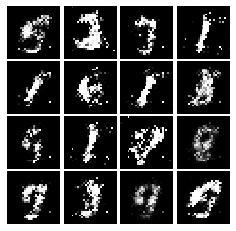


Iter: 1750, D: 1.388, G:0.7771
Iter: 1800, D: 1.326, G:0.7531
Iter: 1850, D: 1.336, G:0.7625
Iter: 1900, D: 1.296, G:0.6928
Iter: 1950, D: 1.402, G:0.8461


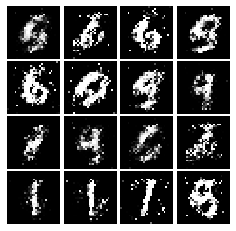


Iter: 2000, D: 1.308, G:0.7661
Iter: 2050, D: 1.406, G:0.7902
Iter: 2100, D: 1.334, G:0.8608
Iter: 2150, D: 1.314, G:0.7837
Iter: 2200, D: 1.304, G:0.7329


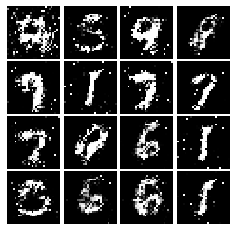


Iter: 2250, D: 1.376, G:0.7404
Iter: 2300, D: 1.348, G:0.8348
Iter: 2350, D: 1.465, G:0.8107
Iter: 2400, D: 1.34, G:0.7173
Iter: 2450, D: 1.422, G:0.7995


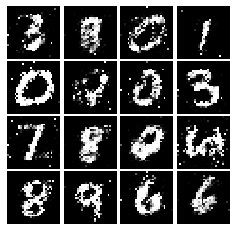


Iter: 2500, D: 1.337, G:0.732
Iter: 2550, D: 1.31, G:0.7267
Iter: 2600, D: 1.366, G:0.7687
Iter: 2650, D: 1.293, G:0.8898
Iter: 2700, D: 1.313, G:0.7494


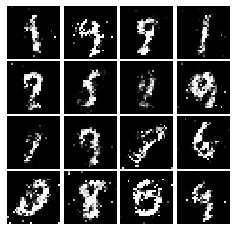


Iter: 2750, D: 1.438, G:0.7848
Iter: 2800, D: 1.35, G:0.8014
Iter: 2850, D: 1.457, G:0.8806
Iter: 2900, D: 1.39, G:0.773
Iter: 2950, D: 1.366, G:0.7316


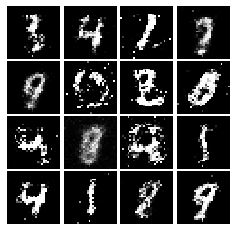


Iter: 3000, D: 1.343, G:0.7466
Iter: 3050, D: 1.352, G:0.8139
Iter: 3100, D: 1.409, G:0.8388
Iter: 3150, D: 1.269, G:0.767
Iter: 3200, D: 1.334, G:0.7024


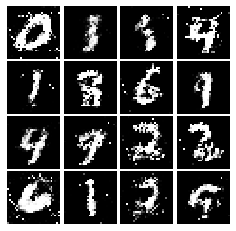


Iter: 3250, D: 1.374, G:0.783
Iter: 3300, D: 1.381, G:0.7552
Iter: 3350, D: 1.29, G:0.7339
Iter: 3400, D: 1.393, G:0.8168
Iter: 3450, D: 1.348, G:0.77


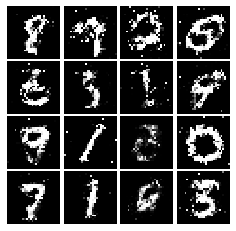


Iter: 3500, D: 1.348, G:0.7616
Iter: 3550, D: 1.471, G:0.8401
Iter: 3600, D: 1.339, G:0.796
Iter: 3650, D: 1.365, G:0.777
Iter: 3700, D: 1.33, G:0.7618


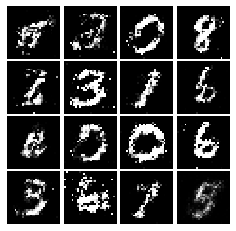


Iter: 3750, D: 1.352, G:0.8141
Iter: 3800, D: 1.34, G:0.6837
Iter: 3850, D: 1.298, G:0.8139
Iter: 3900, D: 1.384, G:0.7962
Iter: 3950, D: 1.382, G:0.767


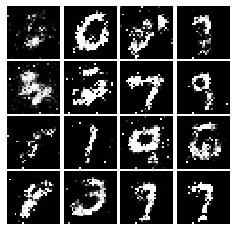


Iter: 4000, D: 1.377, G:0.7975
Iter: 4050, D: 1.272, G:0.6255
Iter: 4100, D: 1.306, G:0.7555
Iter: 4150, D: 1.352, G:0.795
Iter: 4200, D: 1.375, G:0.7548


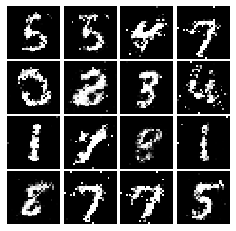


Iter: 4250, D: 1.339, G:0.8453
Final images


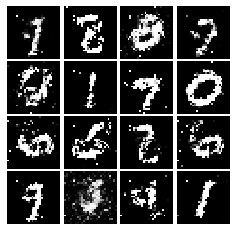

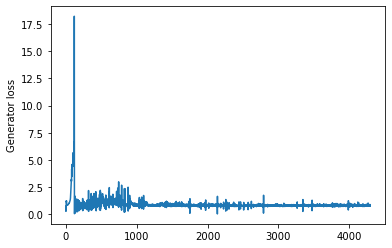

<function print>

In [42]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Gftrl, Dftrl = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)
print
#plt.plot(G_loss)
#plt.ylabel('Generator loss')
#plt.show()


In [23]:
print(Gftrl)

[0.72330421 0.46055895 0.3382017  ... 0.7646749  0.66047537 0.58326185]


In [25]:
## Compare to Adam

In [81]:
def get_solvers_adam(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
        
    
    
    return D_solver, G_solver


In [82]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

# get our solver
D_solver, G_solver = get_solvers_adam()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars) 
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

In [21]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    print (max_iter)
    Gloss = np.zeros(max_iter)
    Dloss = np.zeros(max_iter)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])
        
        #print(G_loss_curr)
        Gloss[it] = G_loss_curr
        Dloss[it] = D_loss_curr
        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()
    
    plt.plot(Gloss)
    plt.ylabel('Generator loss')
    plt.show()
    return  Gloss,Dloss

4296


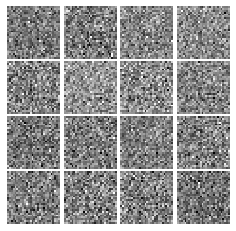


Iter: 0, D: 1.466, G:0.7362
Iter: 50, D: 0.8745, G:2.238
Iter: 100, D: 1.163, G:1.183
Iter: 150, D: 1.076, G:1.475
Iter: 200, D: 1.122, G:1.28


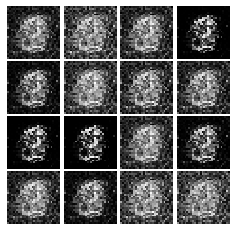


Iter: 250, D: 1.674, G:0.6114
Iter: 300, D: 1.009, G:2.09
Iter: 350, D: 1.27, G:1.522
Iter: 400, D: 0.8604, G:1.986
Iter: 450, D: 1.123, G:1.876


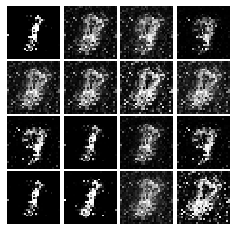


Iter: 500, D: 0.8968, G:1.328
Iter: 550, D: 1.158, G:1.813
Iter: 600, D: 1.173, G:1.242
Iter: 650, D: 0.9341, G:1.627
Iter: 700, D: 1.253, G:0.9574


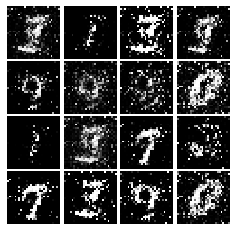


Iter: 750, D: 0.9593, G:1.53
Iter: 800, D: 1.127, G:1.277
Iter: 850, D: 1.164, G:0.957
Iter: 900, D: 1.354, G:1.087
Iter: 950, D: 1.076, G:2.115


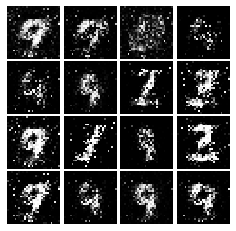


Iter: 1000, D: 1.518, G:0.8779
Iter: 1050, D: 1.709, G:0.2524
Iter: 1100, D: 1.177, G:1.113
Iter: 1150, D: 1.19, G:0.9904
Iter: 1200, D: 2.143, G:1.349


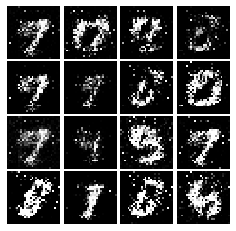


Iter: 1250, D: 1.299, G:1.21
Iter: 1300, D: 1.288, G:1.383
Iter: 1350, D: 1.389, G:1.885
Iter: 1400, D: 1.32, G:0.7592
Iter: 1450, D: 1.378, G:0.9804


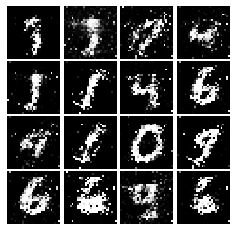


Iter: 1500, D: 1.318, G:0.9043
Iter: 1550, D: 1.309, G:0.5721
Iter: 1600, D: 1.265, G:0.9073
Iter: 1650, D: 1.412, G:0.8753
Iter: 1700, D: 1.302, G:0.9621


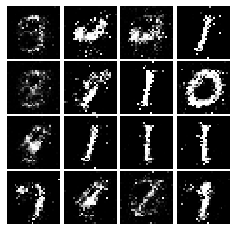


Iter: 1750, D: 1.297, G:0.9816
Iter: 1800, D: 1.325, G:0.8631
Iter: 1850, D: 1.848, G:0.7783
Iter: 1900, D: 1.453, G:0.8066
Iter: 1950, D: 1.249, G:0.8994


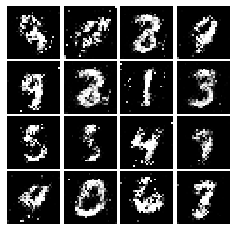


Iter: 2000, D: 1.317, G:0.8069
Iter: 2050, D: 1.304, G:0.8575
Iter: 2100, D: 1.391, G:0.8045
Iter: 2150, D: 1.305, G:1.005
Iter: 2200, D: 1.301, G:0.8836


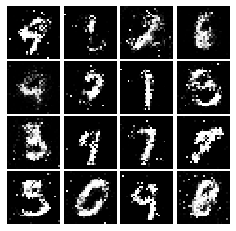


Iter: 2250, D: 1.294, G:0.9129
Iter: 2300, D: 1.312, G:0.933
Iter: 2350, D: 1.328, G:0.841
Iter: 2400, D: 1.271, G:0.8933
Iter: 2450, D: 1.294, G:0.8877


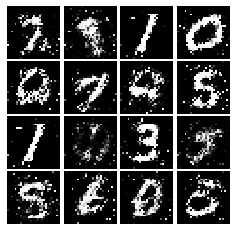


Iter: 2500, D: 1.289, G:0.8249
Iter: 2550, D: 1.31, G:0.7554
Iter: 2600, D: 1.284, G:0.9315
Iter: 2650, D: 1.272, G:0.9824
Iter: 2700, D: 1.303, G:0.8082


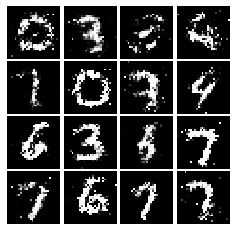


Iter: 2750, D: 1.326, G:0.8743
Iter: 2800, D: 1.257, G:0.8493
Iter: 2850, D: 1.362, G:0.9207
Iter: 2900, D: 1.281, G:0.7671
Iter: 2950, D: 1.302, G:0.818


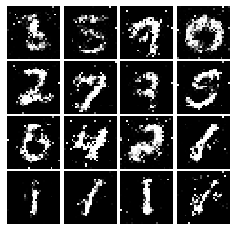


Iter: 3000, D: 1.302, G:0.78
Iter: 3050, D: 1.322, G:0.7984
Iter: 3100, D: 1.275, G:0.7374
Iter: 3150, D: 1.324, G:0.9083
Iter: 3200, D: 1.338, G:1.002


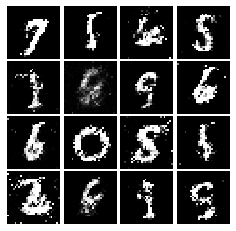


Iter: 3250, D: 1.275, G:0.8395
Iter: 3300, D: 1.336, G:0.9226
Iter: 3350, D: 1.275, G:0.8086
Iter: 3400, D: 1.302, G:0.7965
Iter: 3450, D: 1.275, G:0.8251


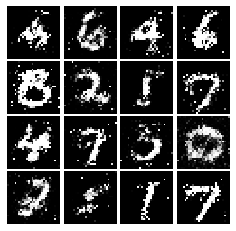


Iter: 3500, D: 1.338, G:0.8875
Iter: 3550, D: 1.333, G:0.8062
Iter: 3600, D: 1.34, G:0.7912
Iter: 3650, D: 1.328, G:0.7471
Iter: 3700, D: 1.393, G:0.8749


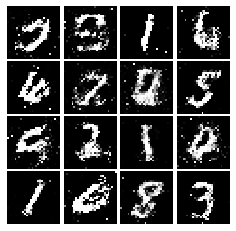


Iter: 3750, D: 1.294, G:0.8461
Iter: 3800, D: 1.331, G:0.7907
Iter: 3850, D: 1.334, G:0.773
Iter: 3900, D: 1.294, G:0.7316
Iter: 3950, D: 1.297, G:0.8182


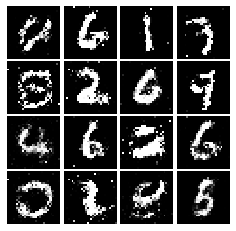


Iter: 4000, D: 1.304, G:0.7742
Iter: 4050, D: 1.411, G:0.8337
Iter: 4100, D: 1.351, G:0.8481
Iter: 4150, D: 1.33, G:0.8621
Iter: 4200, D: 1.278, G:0.7713


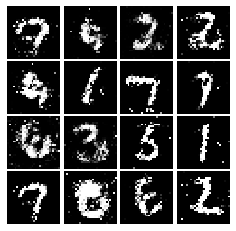


Iter: 4250, D: 1.3, G:0.7375
Final images


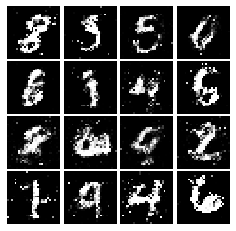

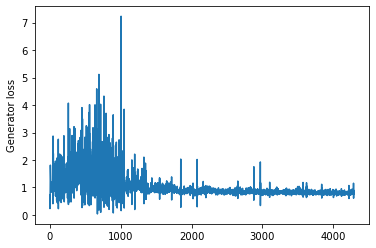

<function print>

In [46]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Gadam,Dadam = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

#plt.plot(G_loss)
#plt.ylabel('Generator loss')
#plt.show()


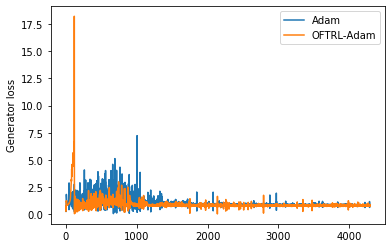

In [51]:
plt.plot(Gadam)
plt.plot(Gftrl)
plt.ylabel('Generator loss')
plt.legend(["Adam","OFTRL-Adam"])
plt.show()

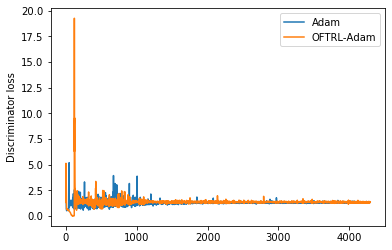

In [50]:
D1 = plt.plot(Dadam)
D2 = plt.plot(Dftrl)
plt.ylabel('Discriminator loss')
plt.legend(["Adam","OFTRL-Adam"])
plt.show()

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [55]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    part1 = 0.5 * tf.reduce_mean(tf.square(score_real - 1))
    part2 = 0.5 * tf.reduce_mean(tf.square(score_fake))
    D_loss = part1 + part2
    G_loss = 0.5 * tf.reduce_mean(tf.square(score_fake - 1))
    return D_loss, G_loss

In [56]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

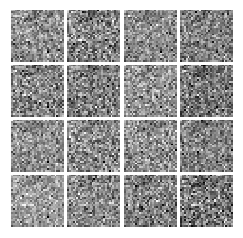


Iter: 0, D: 2.429, G:0.4594
Iter: 50, D: 0.03757, G:0.5256
Iter: 100, D: 0.02563, G:0.5515
Iter: 150, D: 0.007944, G:0.5168
Iter: 200, D: 0.5221, G:0.8073


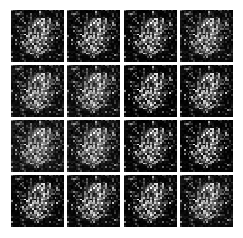


Iter: 250, D: 0.2358, G:0.4936
Iter: 300, D: 0.3675, G:0.7282
Iter: 350, D: 0.1363, G:0.2359
Iter: 400, D: 0.1349, G:0.4215
Iter: 450, D: 0.3937, G:0.02547


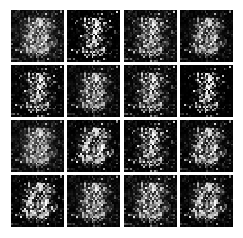


Iter: 500, D: 0.227, G:0.8431
Iter: 550, D: 0.1143, G:0.4333
Iter: 600, D: 0.1133, G:0.4851
Iter: 650, D: 0.1363, G:0.2911
Iter: 700, D: 0.1296, G:0.565


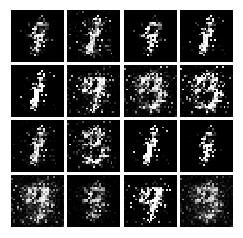


Iter: 750, D: 0.16, G:0.3449
Iter: 800, D: 0.1386, G:0.3819
Iter: 850, D: 0.1473, G:0.3596
Iter: 900, D: 0.1324, G:0.5286
Iter: 950, D: 0.1203, G:1.381


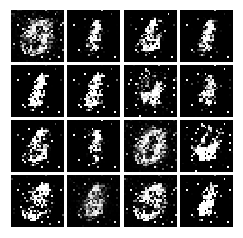


Iter: 1000, D: 0.2089, G:0.4143
Iter: 1050, D: 0.1322, G:0.3439
Iter: 1100, D: 0.1801, G:0.7738
Iter: 1150, D: 0.1391, G:0.3291
Iter: 1200, D: 0.1771, G:0.2377


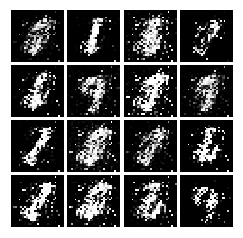


Iter: 1250, D: 0.1311, G:0.3317
Iter: 1300, D: 0.1742, G:0.1448
Iter: 1350, D: 0.153, G:0.1974
Iter: 1400, D: 0.159, G:0.2414
Iter: 1450, D: 0.1349, G:0.2701


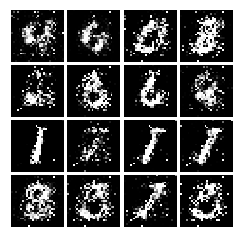


Iter: 1500, D: 0.1707, G:0.2653
Iter: 1550, D: 0.1993, G:0.212
Iter: 1600, D: 0.1761, G:0.2082
Iter: 1650, D: 0.1987, G:0.2104
Iter: 1700, D: 0.2313, G:0.2142


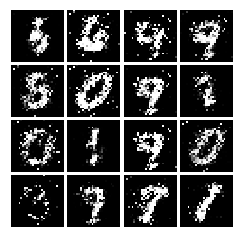


Iter: 1750, D: 0.2241, G:0.2865
Iter: 1800, D: 0.1995, G:0.1865
Iter: 1850, D: 0.2336, G:0.1738
Iter: 1900, D: 0.2114, G:0.2246
Iter: 1950, D: 0.2231, G:0.1865


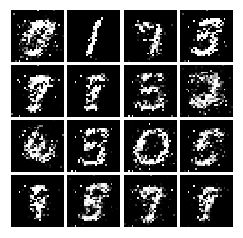


Iter: 2000, D: 0.2108, G:0.2068
Iter: 2050, D: 0.2084, G:0.2109
Iter: 2100, D: 0.2194, G:0.1742
Iter: 2150, D: 0.2128, G:0.2001
Iter: 2200, D: 0.2276, G:0.1563


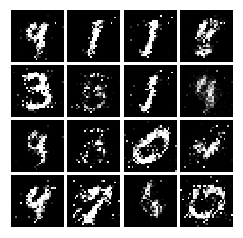


Iter: 2250, D: 0.2132, G:0.1918
Iter: 2300, D: 0.213, G:0.2144
Iter: 2350, D: 0.2076, G:0.2015
Iter: 2400, D: 0.2286, G:0.1756
Iter: 2450, D: 0.2133, G:0.1786


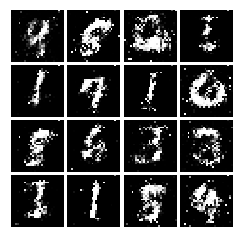


Iter: 2500, D: 0.2305, G:0.1748
Iter: 2550, D: 0.2099, G:0.221
Iter: 2600, D: 0.2309, G:0.1788
Iter: 2650, D: 0.2483, G:0.2138
Iter: 2700, D: 0.2062, G:0.181


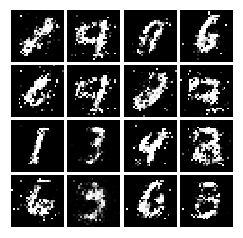


Iter: 2750, D: 0.214, G:0.1772
Iter: 2800, D: 0.2314, G:0.1597
Iter: 2850, D: 0.2421, G:0.2328
Iter: 2900, D: 0.2328, G:0.195
Iter: 2950, D: 0.2238, G:0.2164


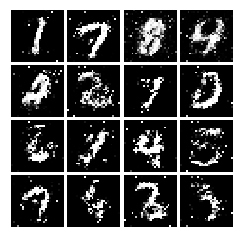


Iter: 3000, D: 0.2189, G:0.1809
Iter: 3050, D: 0.2285, G:0.1592
Iter: 3100, D: 0.2051, G:0.1849
Iter: 3150, D: 0.2543, G:0.1804
Iter: 3200, D: 0.2367, G:0.1629


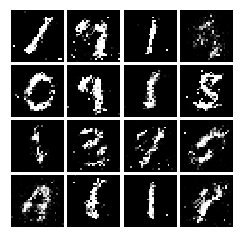


Iter: 3250, D: 0.2045, G:0.1628
Iter: 3300, D: 0.2148, G:0.1678
Iter: 3350, D: 0.244, G:0.1917
Iter: 3400, D: 0.2128, G:0.195
Iter: 3450, D: 0.2243, G:0.1743


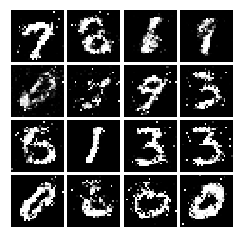


Iter: 3500, D: 0.2127, G:0.1605
Iter: 3550, D: 0.2336, G:0.1884
Iter: 3600, D: 0.2232, G:0.1758
Iter: 3650, D: 0.215, G:0.1898
Iter: 3700, D: 0.2445, G:0.1872


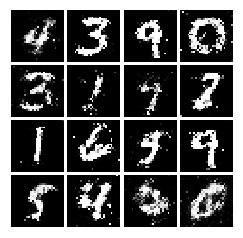


Iter: 3750, D: 0.2286, G:0.1698
Iter: 3800, D: 0.2062, G:0.1809
Iter: 3850, D: 0.2225, G:0.1472
Iter: 3900, D: 0.2123, G:0.1817
Iter: 3950, D: 0.2278, G:0.1827


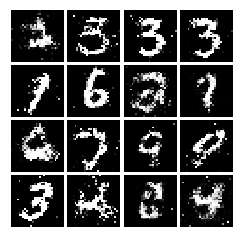


Iter: 4000, D: 0.2239, G:0.162
Iter: 4050, D: 0.2246, G:0.1541
Iter: 4100, D: 0.2103, G:0.1764
Iter: 4150, D: 0.2209, G:0.1862
Iter: 4200, D: 0.2251, G:0.1718


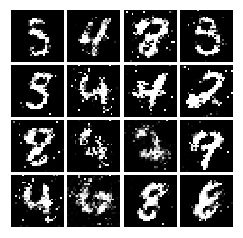


Iter: 4250, D: 0.2189, G:0.1935
Final images


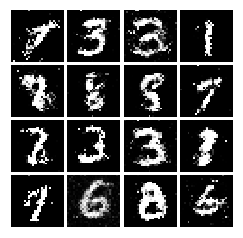

In [53]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Deep Convolutional GANs
#### Discriminator


In [52]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
#         print(x.get_shape().as_list())
        x = tf.reshape(x,shape = [-1,28,28,1])
        x = tf.layers.conv2d(x, 32, 5, padding='valid', activation = leaky_relu)
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x, 64, 5, padding='valid', activation = leaky_relu)
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.reshape(x, shape= [-1,4 * 4 * 64])
        x = tf.layers.dense(x,4 * 4 * 64, activation= leaky_relu)
        logits = tf.layers.dense(x, 1)        
        return logits

#### Generator

In [53]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        x = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        x = tf.layers.batch_normalization(x)
        x = tf.layers.dense(x, 7 * 7 * 128, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x)
        x = tf.reshape(x , [-1, 7, 7, 128])
        x = tf.layers.conv2d_transpose(x,64,4,2,activation=tf.nn.relu,padding='same')
        x = tf.layers.batch_normalization(x)
        img = tf.layers.conv2d_transpose(x,1,4,2,activation=tf.nn.tanh,padding='same')
        return img

We have to recreate our network since we've changed our functions.

In [57]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)
# G_sample = G_sample[:,:28,:28,:]

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator') # remove these and check
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

4296


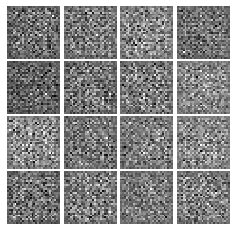


Iter: 0, D: 0.4925, G:0.2664
Iter: 50, D: 0.0625, G:0.7641
Iter: 100, D: 0.05433, G:0.7727
Iter: 150, D: 0.3236, G:0.2726
Iter: 200, D: 0.1372, G:0.1711


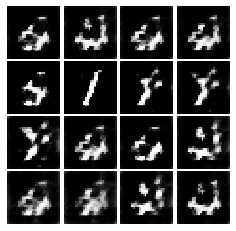


Iter: 250, D: 0.2, G:0.05809
Iter: 300, D: 0.1251, G:0.556
Iter: 350, D: 0.1483, G:0.2699
Iter: 400, D: 0.1504, G:0.3882
Iter: 450, D: 0.183, G:0.1725


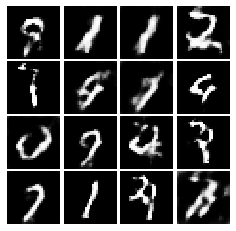


Iter: 500, D: 0.131, G:0.2233
Iter: 550, D: 0.1489, G:0.2927
Iter: 600, D: 0.1335, G:0.3164
Iter: 650, D: 0.1987, G:0.2829
Iter: 700, D: 0.1413, G:0.2119


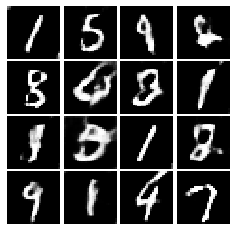


Iter: 750, D: 0.1879, G:0.1922
Iter: 800, D: 0.1539, G:0.3715
Iter: 850, D: 0.15, G:0.2651
Iter: 900, D: 0.1931, G:0.19
Iter: 950, D: 0.2067, G:0.1491


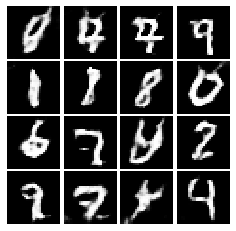


Iter: 1000, D: 0.1799, G:0.2485
Iter: 1050, D: 0.2104, G:0.2294
Iter: 1100, D: 0.2255, G:0.1399
Iter: 1150, D: 0.1839, G:0.2312
Iter: 1200, D: 0.1935, G:0.3456


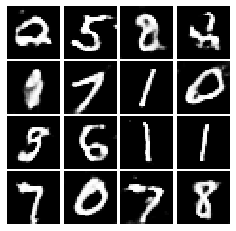


Iter: 1250, D: 0.1932, G:0.2122
Iter: 1300, D: 0.1688, G:0.2895
Iter: 1350, D: 0.2052, G:0.2131
Iter: 1400, D: 0.242, G:0.1116
Iter: 1450, D: 0.2106, G:0.1741


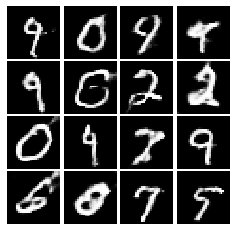


Iter: 1500, D: 0.231, G:0.1555
Iter: 1550, D: 0.1864, G:0.2628
Iter: 1600, D: 0.1706, G:0.2894
Iter: 1650, D: 0.1835, G:0.2178
Iter: 1700, D: 0.1704, G:0.4368


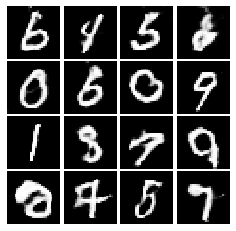


Iter: 1750, D: 0.2062, G:0.325
Iter: 1800, D: 0.2431, G:0.1488
Iter: 1850, D: 0.214, G:0.1521
Iter: 1900, D: 0.2525, G:0.1392
Iter: 1950, D: 0.2092, G:0.1937


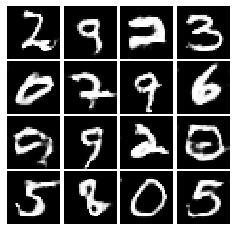


Iter: 2000, D: 0.2275, G:0.1185
Iter: 2050, D: 0.1891, G:0.1866
Iter: 2100, D: 0.1882, G:0.1764
Iter: 2150, D: 0.1939, G:0.194
Iter: 2200, D: 0.1609, G:0.1285


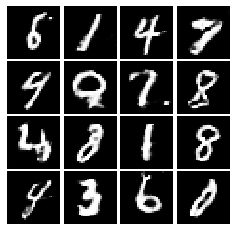


Iter: 2250, D: 0.1655, G:0.1817
Iter: 2300, D: 0.2097, G:0.169
Iter: 2350, D: 0.2259, G:0.1043
Iter: 2400, D: 0.1947, G:0.1615
Iter: 2450, D: 0.2333, G:0.1635


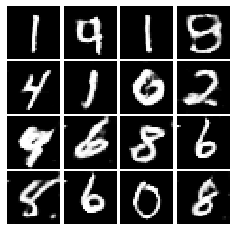


Iter: 2500, D: 0.176, G:0.1628
Iter: 2550, D: 0.1751, G:0.358
Iter: 2600, D: 0.2485, G:0.168
Iter: 2650, D: 0.2527, G:0.1291
Iter: 2700, D: 0.2024, G:0.0132


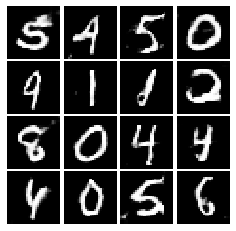


Iter: 2750, D: 0.2419, G:0.1166
Iter: 2800, D: 0.2421, G:0.09781
Iter: 2850, D: 0.2282, G:0.1186
Iter: 2900, D: 0.1748, G:0.2523
Iter: 2950, D: 0.1925, G:0.2951


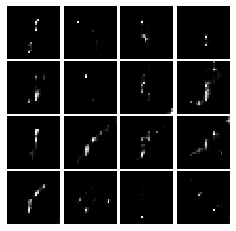


Iter: 3000, D: 0.0446, G:0.3875
Iter: 3050, D: 0.3108, G:0.02937
Iter: 3100, D: 0.3007, G:0.07342
Iter: 3150, D: 0.2359, G:0.1425
Iter: 3200, D: 0.2385, G:0.1508


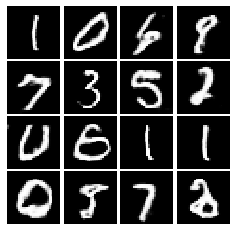


Iter: 3250, D: 0.2259, G:0.1511
Iter: 3300, D: 0.2304, G:0.1408
Iter: 3350, D: 0.2146, G:0.1556
Iter: 3400, D: 0.1808, G:0.1312
Iter: 3450, D: 0.2495, G:0.1498


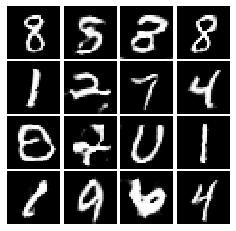


Iter: 3500, D: 0.201, G:0.1795
Iter: 3550, D: 0.2405, G:0.1309
Iter: 3600, D: 0.237, G:0.1279
Iter: 3650, D: 0.214, G:0.1295
Iter: 3700, D: 0.2632, G:0.1093


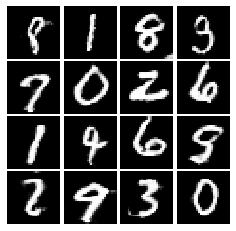


Iter: 3750, D: 0.2949, G:0.1455
Iter: 3800, D: 0.1637, G:0.2245
Iter: 3850, D: 0.1897, G:0.2222
Iter: 3900, D: 0.1969, G:0.1861
Iter: 3950, D: 0.3363, G:0.1936


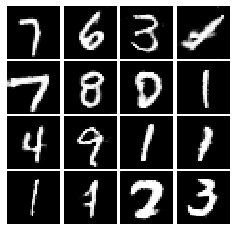


Iter: 4000, D: 0.2032, G:0.11
Iter: 4050, D: 0.2238, G:0.1352
Iter: 4100, D: 0.2228, G:0.1347
Iter: 4150, D: 0.1851, G:0.1573
Iter: 4200, D: 0.1755, G:0.07649


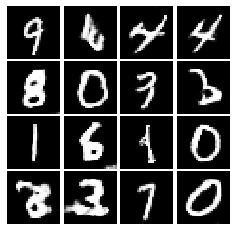


Iter: 4250, D: 0.1566, G:0.162
Final images


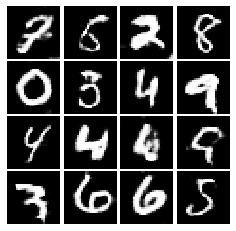

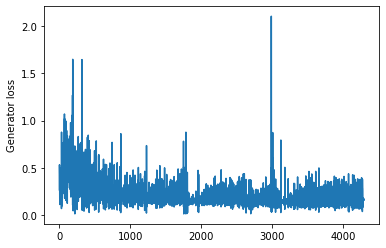

In [58]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Gftrl,Dftrl = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

In [59]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)
# G_sample = G_sample[:,:28,:28,:]

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers_adam()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator') # remove these and check
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

4296


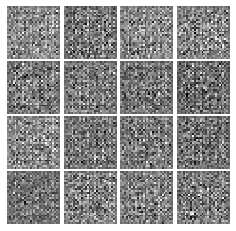


Iter: 0, D: 0.2812, G:0.3805
Iter: 50, D: 0.03071, G:0.7103
Iter: 100, D: 0.004134, G:0.5192
Iter: 150, D: 0.003963, G:0.5806
Iter: 200, D: 0.01116, G:0.6445


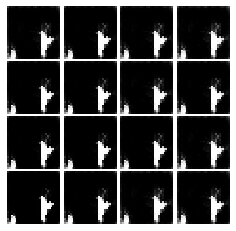


Iter: 250, D: 0.004241, G:0.485
Iter: 300, D: 0.04592, G:0.4346
Iter: 350, D: 0.0653, G:0.617
Iter: 400, D: 0.08825, G:0.3358
Iter: 450, D: 0.08648, G:0.4815


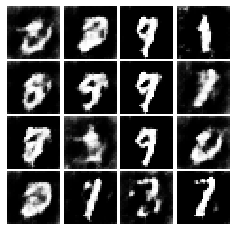


Iter: 500, D: 0.1147, G:0.2425
Iter: 550, D: 0.1103, G:0.3794
Iter: 600, D: 0.1012, G:0.3304
Iter: 650, D: 0.103, G:0.3182
Iter: 700, D: 0.1215, G:0.3046


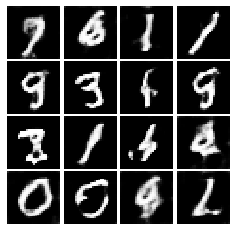


Iter: 750, D: 0.1259, G:0.2747
Iter: 800, D: 0.1414, G:0.2856
Iter: 850, D: 0.1411, G:0.2832
Iter: 900, D: 0.1327, G:0.3039
Iter: 950, D: 0.1496, G:0.2735


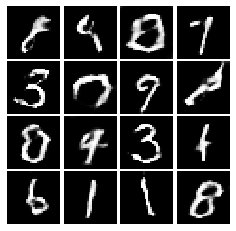


Iter: 1000, D: 0.1388, G:0.2861
Iter: 1050, D: 0.1567, G:0.2248
Iter: 1100, D: 0.1562, G:0.2309
Iter: 1150, D: 0.1454, G:0.314
Iter: 1200, D: 0.1631, G:0.2595


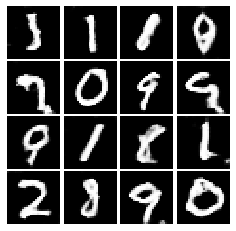


Iter: 1250, D: 0.1875, G:0.3137
Iter: 1300, D: 0.1499, G:0.2089
Iter: 1350, D: 0.2052, G:0.3329
Iter: 1400, D: 0.1896, G:0.2438
Iter: 1450, D: 0.1954, G:0.1418


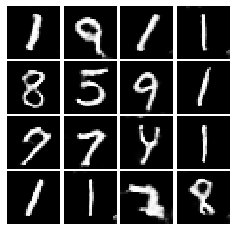


Iter: 1500, D: 0.1753, G:0.1675
Iter: 1550, D: 0.1613, G:0.2382
Iter: 1600, D: 0.1553, G:0.2444
Iter: 1650, D: 0.1943, G:0.251
Iter: 1700, D: 0.1821, G:0.2328


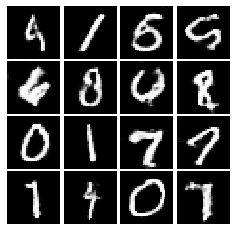


Iter: 1750, D: 0.187, G:0.1926
Iter: 1800, D: 0.1699, G:0.3155
Iter: 1850, D: 0.166, G:0.2274
Iter: 1900, D: 0.1638, G:0.1951
Iter: 1950, D: 0.1765, G:0.2324


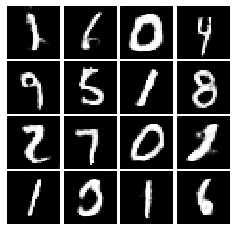


Iter: 2000, D: 0.1654, G:0.2221
Iter: 2050, D: 0.1542, G:0.1751
Iter: 2100, D: 0.1856, G:0.1981
Iter: 2150, D: 0.1661, G:0.3008
Iter: 2200, D: 0.1674, G:0.2032


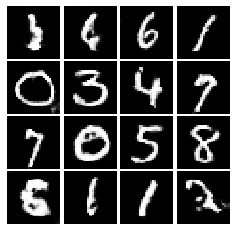


Iter: 2250, D: 0.1579, G:0.2265
Iter: 2300, D: 0.1689, G:0.2571
Iter: 2350, D: 0.166, G:0.2434
Iter: 2400, D: 0.163, G:0.2424
Iter: 2450, D: 0.1832, G:0.1628


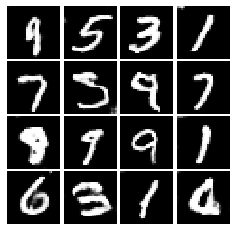


Iter: 2500, D: 0.1629, G:0.2639
Iter: 2550, D: 0.1659, G:0.2059
Iter: 2600, D: 0.1682, G:0.2738
Iter: 2650, D: 0.151, G:0.2546
Iter: 2700, D: 0.1861, G:0.217


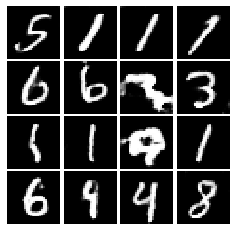


Iter: 2750, D: 0.1759, G:0.2556
Iter: 2800, D: 0.1753, G:0.2098
Iter: 2850, D: 0.246, G:0.06648
Iter: 2900, D: 0.1788, G:0.2978
Iter: 2950, D: 0.1607, G:0.3116


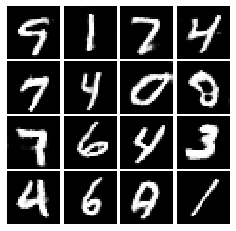


Iter: 3000, D: 0.1792, G:0.2177
Iter: 3050, D: 0.1559, G:0.2974
Iter: 3100, D: 0.1563, G:0.2891
Iter: 3150, D: 0.1352, G:0.206
Iter: 3200, D: 0.15, G:0.166


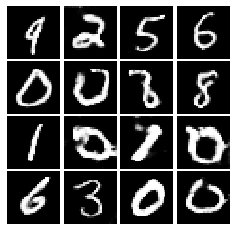


Iter: 3250, D: 0.1552, G:0.2779
Iter: 3300, D: 0.152, G:0.2878
Iter: 3350, D: 0.1439, G:0.1641
Iter: 3400, D: 0.1481, G:0.2915
Iter: 3450, D: 0.1574, G:0.264


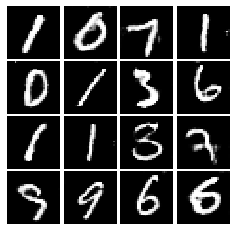


Iter: 3500, D: 0.1573, G:0.3171
Iter: 3550, D: 0.1543, G:0.2024
Iter: 3600, D: 0.1343, G:0.2479
Iter: 3650, D: 0.1473, G:0.2727
Iter: 3700, D: 0.1441, G:0.276


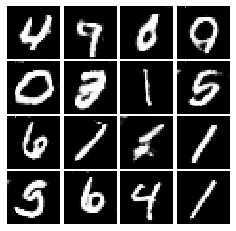


Iter: 3750, D: 0.1363, G:0.2447
Iter: 3800, D: 0.1631, G:0.2658
Iter: 3850, D: 0.1443, G:0.2473
Iter: 3900, D: 0.1439, G:0.2829
Iter: 3950, D: 0.1493, G:0.2219


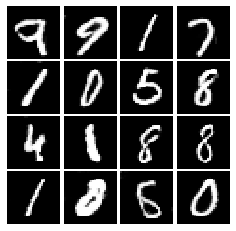


Iter: 4000, D: 0.1385, G:0.3457
Iter: 4050, D: 0.1336, G:0.2978
Iter: 4100, D: 0.1281, G:0.2496
Iter: 4150, D: 0.1482, G:0.2576
Iter: 4200, D: 0.1388, G:0.3047


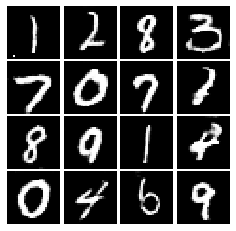


Iter: 4250, D: 0.1357, G:0.3186
Final images


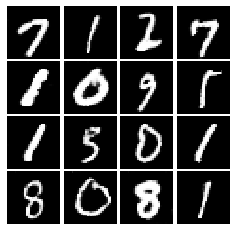

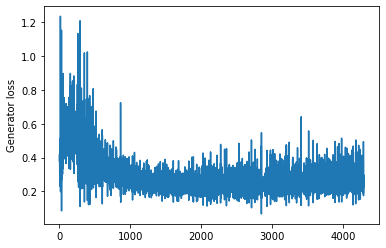

In [60]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    Gadam,Dadam = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

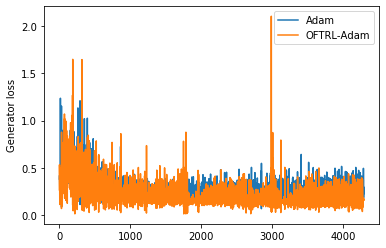

In [61]:
plt.plot(Gadam)
plt.plot(Gftrl)
plt.ylabel('Generator loss')
plt.legend(["Adam","OFTRL-Adam"])
plt.show()

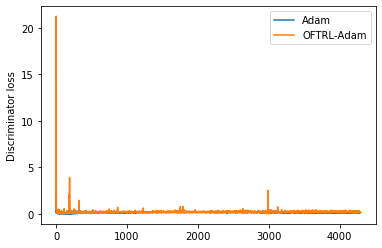

In [62]:

D1 = plt.plot(Dadam)
D2 = plt.plot(Dftrl)
plt.ylabel('Discriminator loss')
plt.legend(["Adam","OFTRL-Adam"])
plt.show()

# WGAN-GP 

In [63]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,64,4,2,padding='valid',activation=leaky_relu)
        x = tf.layers.conv2d(x,128,4,2,padding='valid',activation=leaky_relu)
        x = tf.layers.batch_normalization(x)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x,1024,activation=leaky_relu)
        logits = tf.layers.dense(x,1)
        return logits

In [64]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

Instructions for updating:
Use keras.layers.flatten instead.


In [68]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = -( tf.reduce_mean(logits_real) - tf.reduce_mean(logits_fake) )
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform(shape = [batch_size, 1],minval = 0,maxval = 1)
    x_hat = eps * x + (1 - eps) * tf.reshape(G_sample, [batch_size, -1])

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat),x_hat)

    grad_norm = tf.norm(grad_D_x_hat)
    grad_pen = lam * tf.square(grad_norm-1)
    
    D_loss += grad_pen



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

2578


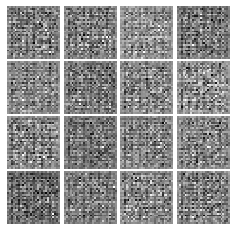


Iter: 0, D: 0.117, G:-0.128
Iter: 50, D: 0.1643, G:-3.284
Iter: 100, D: -1.455, G:-1.627
Iter: 150, D: -0.6795, G:-1.887
Iter: 200, D: -0.5057, G:-3.218


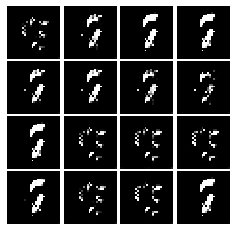


Iter: 250, D: -1.024, G:-2.112
Iter: 300, D: -0.248, G:0.6125
Iter: 350, D: -0.02869, G:0.07437
Iter: 400, D: 0.1969, G:-0.002797
Iter: 450, D: -0.1195, G:-0.5178


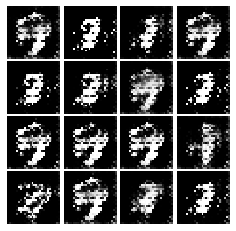


Iter: 500, D: 0.2152, G:0.00929
Iter: 550, D: -0.1468, G:-2.079
Iter: 600, D: -0.09326, G:-3.187
Iter: 650, D: 0.6096, G:1.077
Iter: 700, D: -0.1821, G:-0.2895


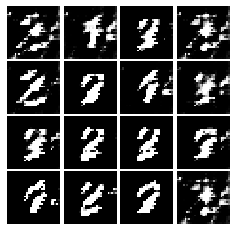


Iter: 750, D: 0.1615, G:-0.01957
Iter: 800, D: 0.02009, G:-0.8524
Iter: 850, D: 0.09732, G:-0.8829
Iter: 900, D: -0.07636, G:-0.2136
Iter: 950, D: 0.04778, G:-0.3014


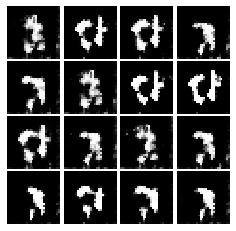


Iter: 1000, D: -0.02686, G:-1.417
Iter: 1050, D: -0.03135, G:-1.654
Iter: 1100, D: 0.05044, G:-3.041
Iter: 1150, D: -0.1108, G:-2.797
Iter: 1200, D: 0.009206, G:-3.191


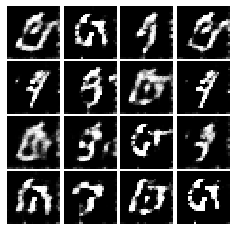


Iter: 1250, D: -0.1743, G:-3.185
Iter: 1300, D: 1.234, G:-0.4524
Iter: 1350, D: -0.3987, G:0.3408
Iter: 1400, D: 0.4083, G:-3.4
Iter: 1450, D: 0.3137, G:-1.863


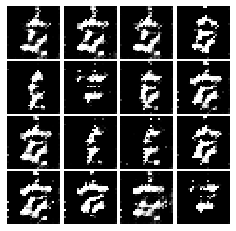


Iter: 1500, D: -0.01787, G:-2.178
Iter: 1550, D: -0.00536, G:-2.506
Iter: 1600, D: 0.05912, G:-2.514
Iter: 1650, D: 0.06038, G:-2.447
Iter: 1700, D: 2.281, G:-2.207


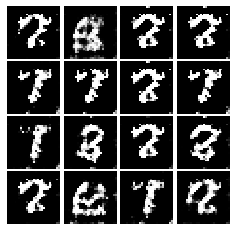


Iter: 1750, D: 0.2354, G:2.057
Iter: 1800, D: -0.01429, G:2.304
Iter: 1850, D: -0.004387, G:2.051
Iter: 1900, D: 0.156, G:1.028
Iter: 1950, D: 0.002502, G:2.484


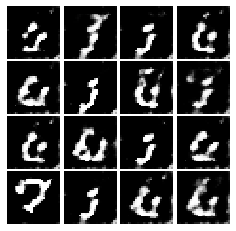


Iter: 2000, D: -0.03263, G:2.06
Iter: 2050, D: 0.07653, G:1.267
Iter: 2100, D: 0.1183, G:0.8135
Iter: 2150, D: 0.09266, G:0.9679
Iter: 2200, D: 0.001477, G:1.06


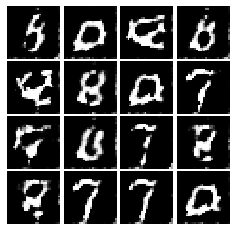


Iter: 2250, D: 0.04499, G:1.326
Iter: 2300, D: 0.05193, G:0.2137
Iter: 2350, D: 0.007973, G:0.073
Iter: 2400, D: 0.02674, G:0.1261
Iter: 2450, D: -0.0202, G:0.5818


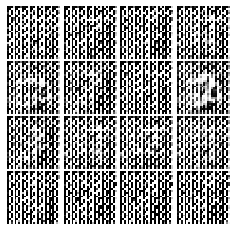


Iter: 2500, D: 1.065, G:-2.349
Iter: 2550, D: -0.01197, G:-3.939
Final images


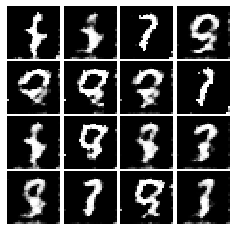

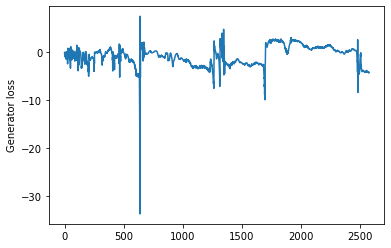

In [69]:
with get_session() as sess:
    # sess = get_session()
    sess.run(tf.global_variables_initializer())
    Gftrl,Dftrl = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=6)

In [71]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers_adam()

In [72]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = -( tf.reduce_mean(logits_real) - tf.reduce_mean(logits_fake) )
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform(shape = [batch_size, 1],minval = 0,maxval = 1)
    x_hat = eps * x + (1 - eps) * tf.reshape(G_sample, [batch_size, -1])

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat),x_hat)

    grad_norm = tf.norm(grad_D_x_hat)
    grad_pen = lam * tf.square(grad_norm-1)
    
    D_loss += grad_pen



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

2578


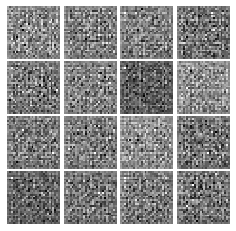


Iter: 0, D: -0.0759, G:-0.05401
Iter: 50, D: -0.542, G:-0.4325
Iter: 100, D: -0.5755, G:-0.6482
Iter: 150, D: -0.05763, G:-1.049
Iter: 200, D: -0.1821, G:-0.8374


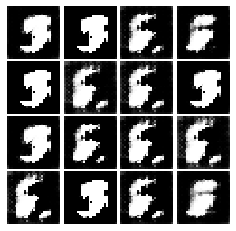


Iter: 250, D: -0.4739, G:-1.877
Iter: 300, D: -0.2428, G:0.2179
Iter: 350, D: -0.2889, G:0.7961
Iter: 400, D: -0.5943, G:0.004343
Iter: 450, D: -0.177, G:0.7786


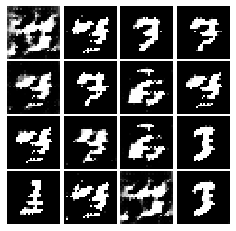


Iter: 500, D: -0.2247, G:2.36
Iter: 550, D: -0.4501, G:0.5372
Iter: 600, D: -0.0733, G:0.3694
Iter: 650, D: -0.3397, G:1.113
Iter: 700, D: -0.2242, G:1.248


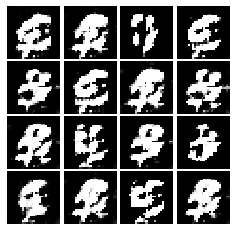


Iter: 750, D: -0.223, G:-0.6106
Iter: 800, D: -0.2444, G:1.249
Iter: 850, D: -0.3849, G:1.439
Iter: 900, D: -0.2246, G:1.302
Iter: 950, D: -0.1038, G:0.2283


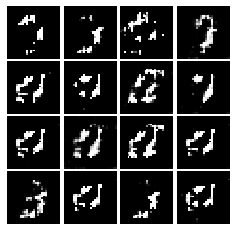


Iter: 1000, D: -0.1282, G:0.4728
Iter: 1050, D: 0.05573, G:0.09615
Iter: 1100, D: 0.1888, G:0.1609
Iter: 1150, D: -0.264, G:-0.1105
Iter: 1200, D: -0.08385, G:-0.2039


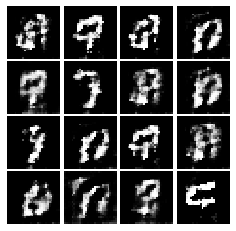


Iter: 1250, D: -0.01412, G:-0.3511
Iter: 1300, D: -0.0701, G:-0.2712
Iter: 1350, D: -0.1521, G:1.005
Iter: 1400, D: -0.09504, G:0.5482
Iter: 1450, D: 0.151, G:2.522


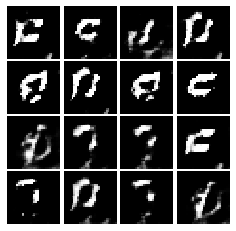


Iter: 1500, D: -0.1127, G:-0.5683
Iter: 1550, D: -0.09432, G:-0.5414
Iter: 1600, D: 0.03744, G:-0.6432
Iter: 1650, D: 0.2821, G:0.3125
Iter: 1700, D: 0.2339, G:-0.1749


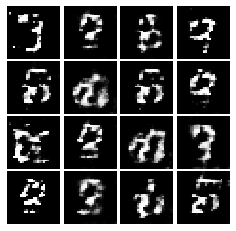


Iter: 1750, D: -0.003684, G:-0.1214
Iter: 1800, D: -0.08608, G:-0.202
Iter: 1850, D: -0.05128, G:0.7395
Iter: 1900, D: 0.02243, G:0.1908
Iter: 1950, D: 0.08521, G:-0.5337


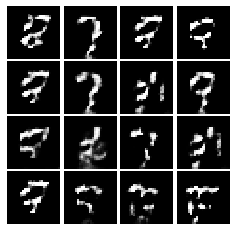


Iter: 2000, D: -0.151, G:0.01172
Iter: 2050, D: 0.07815, G:-0.8806
Iter: 2100, D: -0.1126, G:-0.2007
Iter: 2150, D: -0.01064, G:0.7278
Iter: 2200, D: -0.01106, G:0.03485


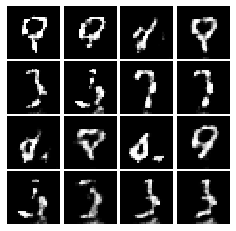


Iter: 2250, D: 0.01664, G:0.04904
Iter: 2300, D: -0.0106, G:0.1074
Iter: 2350, D: -0.1637, G:0.6053
Iter: 2400, D: 0.08656, G:0.4825
Iter: 2450, D: 0.02925, G:0.4502


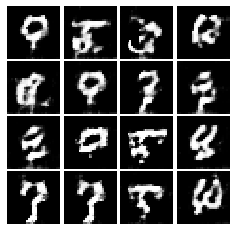


Iter: 2500, D: -0.03393, G:0.5017
Iter: 2550, D: -0.09775, G:0.8869
Final images


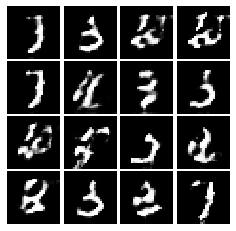

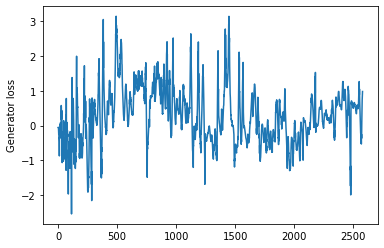

In [73]:
with get_session() as sess:
    # sess = get_session()
    sess.run(tf.global_variables_initializer())
    Gadam,Dadam = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=6)

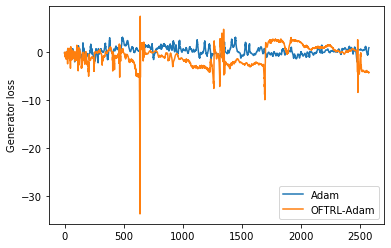

In [74]:
plt.plot(Gadam)
plt.plot(Gftrl)
plt.ylabel('Generator loss')
plt.legend(["Adam","OFTRL-Adam"])
plt.show()

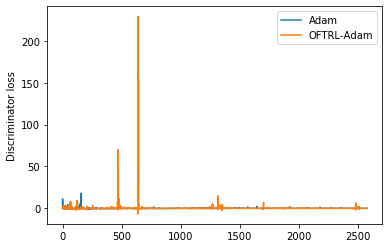

In [75]:
D1 = plt.plot(Dadam)
D2 = plt.plot(Dftrl)
plt.ylabel('Discriminator loss')
plt.legend(["Adam","OFTRL-Adam"])
plt.show()